# Mapping 
### Cette partie du projet permet de visualiser les données du projet. 

In [13]:
#importation des bibliothèques
import numpy as np
import matplotlib.pyplot as plt
import os
%matplotlib inline
import pandas as pd
import geopandas as gpd
from pyproj import Proj
from pyproj import Transformer
import folium
from folium import plugins
from scipy.interpolate import griddata

In [14]:
# Chargement des données
MNTvolcan=np.loadtxt("/workspaces/NiigataYake/data_niigatayake/sujet_14.asc", skiprows=6)
stations=pd.read_csv("/workspaces/NiigataYake/data_niigatayake/sujet_14.txt", sep=';')

In [15]:
#Nettoyage des données
MNTvolcan[MNTvolcan==-32768]=np.nan

In [18]:
#Lecture des métadatas afin  de connaître la structure de la grille raster
ncols=252
nrows=252
cellsize=81.889438374615
xllcorner=225881.003642860858
yllcorner=4079533.684119465295

In [16]:
#Calcul du cadre
xmin=xllcorner
ymin=yllcorner
xmax=xmin+ncols*cellsize
ymax=ymin+nrows*cellsize
cadre=[xmin, xmax, ymin, ymax]

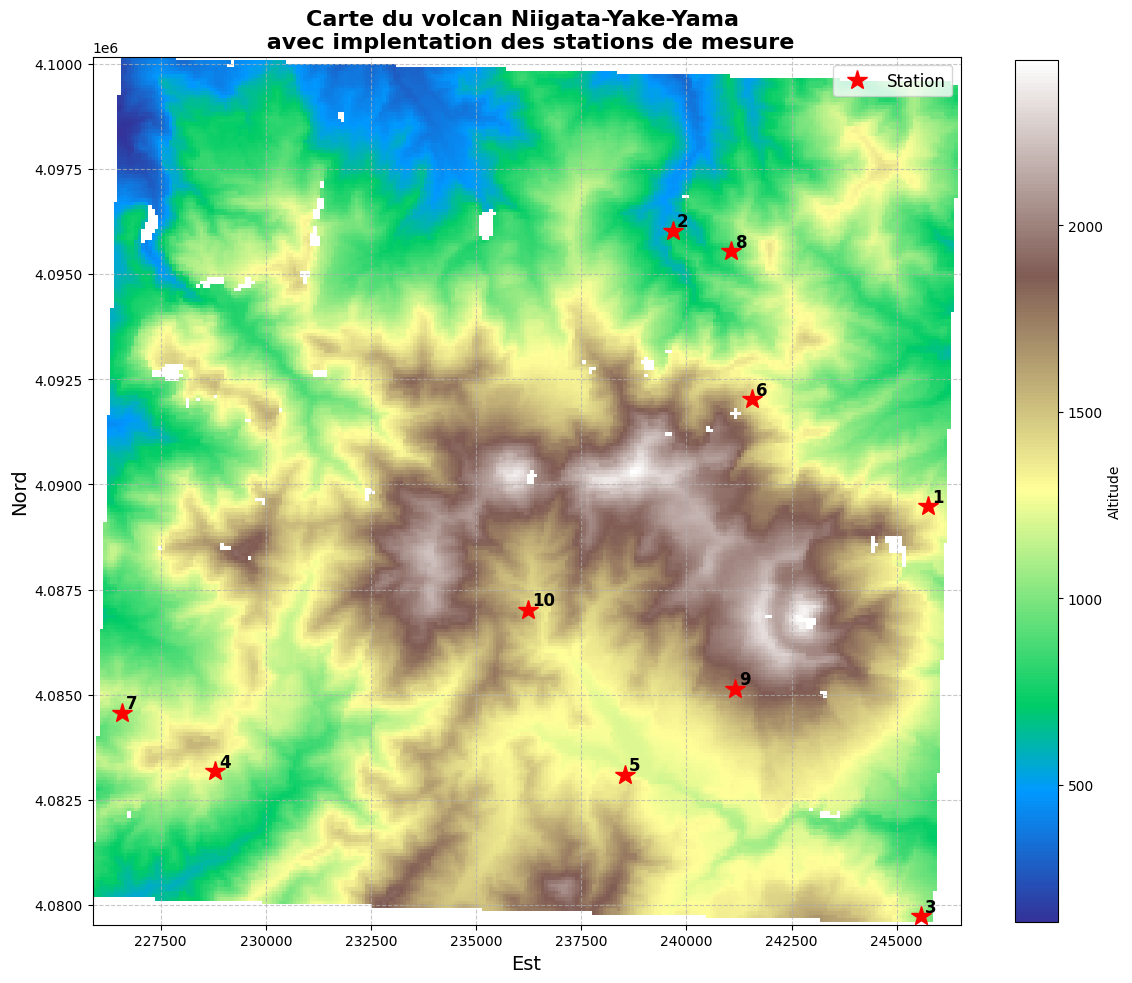

In [17]:
# Affichage de la carte

# Création de la figure
plt.figure(figsize=(14, 14))

# Affichage de l'image de fond
plt.imshow(MNTvolcan, cmap='terrain', extent=cadre)

# Traçage des stations et ajout du texte
for i in range(10):
    plt.plot(stations['Eastern'][i], stations['Northern'][i], '*r', markersize=15, label=f'Station' if i == 0 else "")
    plt.text(stations['Eastern'][i] + 100, stations['Northern'][i] + 100, str(i + 1), color='black', fontsize=12, weight='bold')

# Ajout une barre de couleur
cbar = plt.colorbar(shrink=0.8)
cbar.set_label('Altitude')

# Ajout des étiquettes et un titre
plt.xlabel('Est', fontsize=14)
plt.ylabel('Nord', fontsize=14)
plt.title('Carte du volcan Niigata-Yake-Yama \n avec implentation des stations de mesure', fontsize=16, weight='bold')

# Ajout une légende
plt.legend(loc='upper right', fontsize=12)

# Ajout une grille 
plt.grid(True, linestyle='--', alpha=0.7)

# Enregistrement du graphique dans le dossier 'output' pour pouvoir l'afficher dans le Wiki
output_dir = 'output'
output_path = os.path.join(output_dir, 'carte_stations.png')
plt.savefig(output_path, dpi=300, bbox_inches='tight')

# Affichage du graphique
plt.show()

#### On souhaite maintenant afficher la carte dans le contexte géographique

In [27]:

# Définition du système de coordonnées UTM et EPSG:4326
utm_proj = 'epsg:32654' 
wgs84_proj = 'epsg:4326'

# Création d'un transformateur
transformer = Transformer.from_crs(utm_proj, wgs84_proj)

# Réalisation d'un fonction pour convertir les coordonnées UTM en coordonnées EPSG:4326
def utm_to_latlon(easting, northing):
    """
    On crée une fonction qui convertit les coordonnées UTM en coordonnées EPSG:4326
    """
    lat, lon = transformer.transform(easting, northing)
    return lat, lon


# Copie des données des stations dans un nouveau DataFrame
stations_utm = stations

# Conversion des coordonnées des stations : on applique notre fonction à chaque ligne du DataFrame
stations_utm['Latitude'], stations_utm['Longitude'] = zip(*stations_utm.apply(lambda row: utm_to_latlon(row['Eastern'], row['Northern']), axis=1))

# Affichage des données converties
print(stations_utm[['Station', 'Latitude', 'Longitude']])

   Station   Latitude   Longitude
0        1  36.917110  138.145794
1        2  36.974434  138.075591
2        3  36.829328  138.147222
3        4  36.855631  137.958001
4        5  36.857639  138.067200
5        6  36.938833  138.098103
6        7  36.867525  137.932733
7        8  36.970397  138.091379
8        9  36.876790  138.095855
9       10  36.892391  138.040145


In [28]:
# Conversion des coordonnées du cadre en utilisant la fonction
lat_min, lon_min = utm_to_latlon(cadre[0], cadre[2])
lat_max, lon_max = utm_to_latlon(cadre[1], cadre[3])


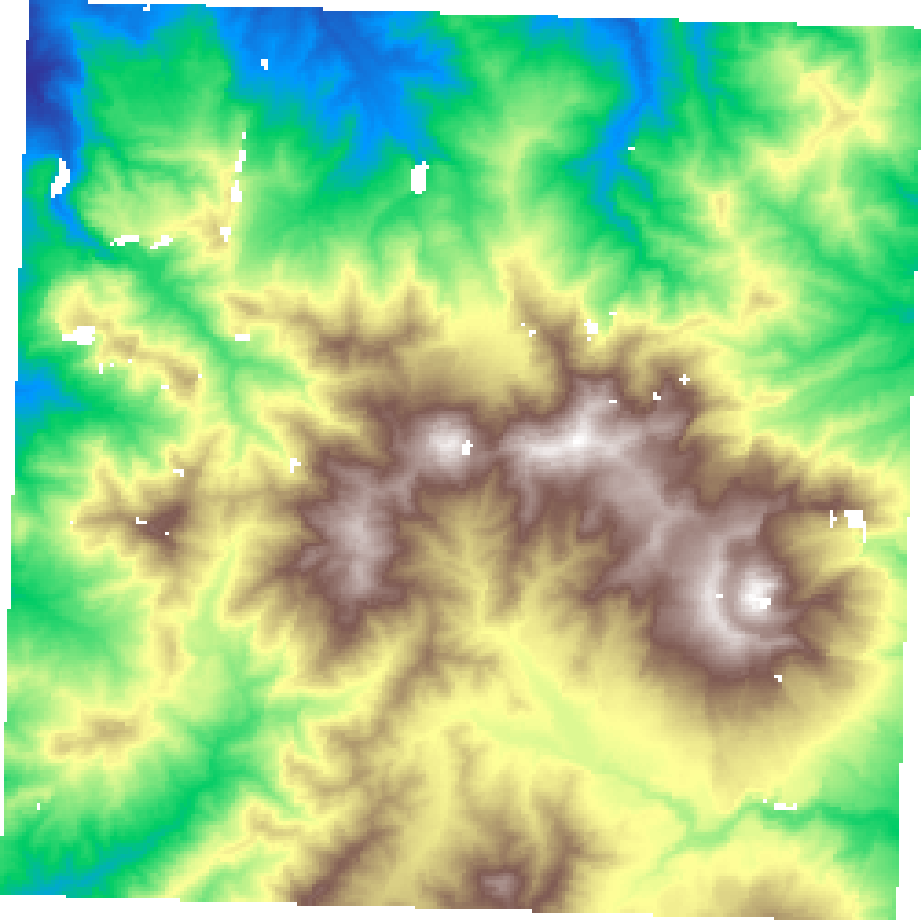

In [29]:
# Conversion des données raster en image
fig, ax = plt.subplots(figsize=(12, 12))
im = ax.imshow(MNTvolcan, cmap='terrain', extent=cadre)
plt.axis('off')
plt.savefig('temp_raster.png', bbox_inches='tight', pad_inches=0)
plt.close(fig)

# Création d'une carte interactive centrée sur le volcan Niigata-Yake-Yama
m = folium.Map(location=[36.918,138.039], zoom_start=11)
folium.CircleMarker([36.918, 138.039], tooltip="Niigata-Yake_Yama").add_to(m)

# Ajout du raster en tant qu'image superposée
folium.raster_layers.ImageOverlay(
    image='temp_raster.png',
    bounds=[[lat_min, lon_min], [lat_max, lon_max]],
    opacity=0.6
).add_to(m)

# Ajout les stations
for i in range(10):
    folium.Marker(
        location=[stations_utm['Latitude'][i], stations_utm['Longitude'][i]],
        popup=f'Station {i+1}',
        icon=folium.Icon(color='red', icon='info-sign')
    ).add_to(m)

# Affichage de la carte m
m


#### Visualisation des déplacements observés sur le terrain

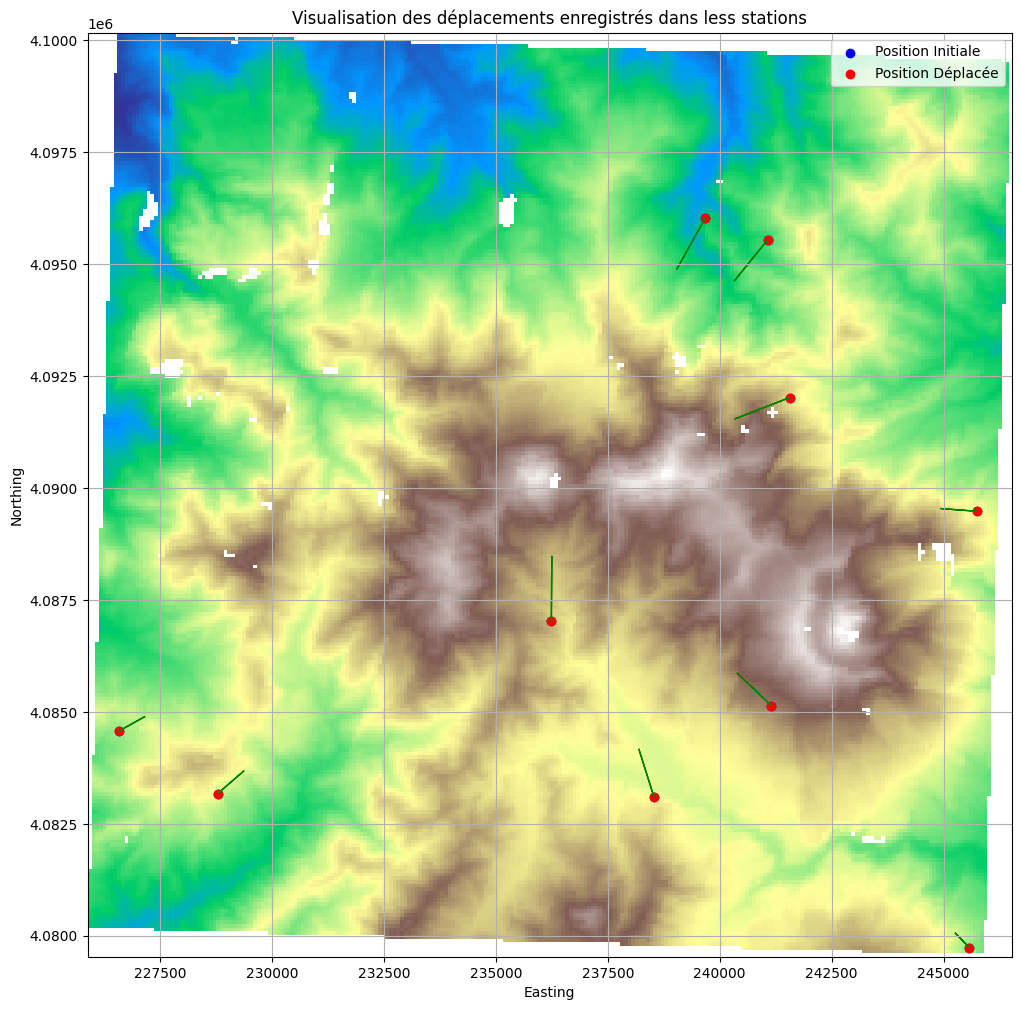

In [10]:
# Calculer les nouvelles positions après déplacement
stations['New_Easting'] = stations['Eastern'] + stations['U_east']
stations['New_Northing'] = stations['Northern'] + stations['U_north']

plt.figure(figsize=(12, 12))

# Afficher la carte
plt.imshow(MNTvolcan, cmap='terrain', extent=cadre)



# Tracer les positions initiales
plt.scatter(stations['Eastern'], stations['Northern'], color='blue', label='Position Initiale')

# Tracer les nouvelles positions
plt.scatter(stations['New_Easting'], stations['New_Northing'], color='red', label='Position Déplacée')

# Tracer les vecteurs de déplacement avec une taille augmentée pour une meilleure visibilité
for i in range(len(stations)):
    plt.arrow(stations['Eastern'][i], stations['Northern'][i], 
              stations['U_east'][i]*10000, stations['U_north'][i]*10000, 
              head_width=0.05, head_length=0.1, fc='green', ec='green', length_includes_head=True)  # ici on agmente scale pour plus de visibilité 

# Ajouter les étiquettes
plt.xlabel('Easting')
plt.ylabel('Northing')
plt.legend()
plt.title('Visualisation des déplacements enregistrés dans less stations')
plt.grid(True)
plt.show()

#### Pour augmenter la visibilité, on réalise une interpolation de la distance entre entre chaque point de MNTvolcan et sa nouvelle position

In [11]:


# Extraction des points connus et leurs déplacements
points_connus = np.array(list(zip(stations['Eastern'], stations['Northern'])))
deplacements = np.array(list(zip(stations['U_east'], stations['U_north'], stations['U_up'])))

# Création d'une grille de points couvrant toute la carte
grille_x, grille_y = np.meshgrid(np.linspace(xmin, xmax, ncols), np.linspace(ymin, ymax, nrows))

# Interpollation les déplacements sur la grille avec la méthode 'cubic'
grille_u_est = griddata(points_connus, deplacements[:, 0], (grille_x, grille_y), method='cubic')
grille_u_nord = griddata(points_connus, deplacements[:, 1], (grille_x, grille_y), method='cubic')
grille_u_haut = griddata(points_connus, deplacements[:, 2], (grille_x, grille_y), method='cubic')


# Calcul les nouvelles positions
new_grid_x = grille_x + grille_u_est
new_grid_y =  grille_y + grille_u_nord


# Calculer la distance entre chaque point de MNTvolcan et sa nouvelle position
distance = np.sqrt((new_grid_x - grille_x)**2 + (new_grid_y - grille_y)**2)


# Retourner la matrice verticalement, qui sont à l'envers par rapport à la matrice MNTvolcan
distance_corrected = np.flipud(distance)
grille_u_haut_corrected = np.flipud(grille_u_haut)



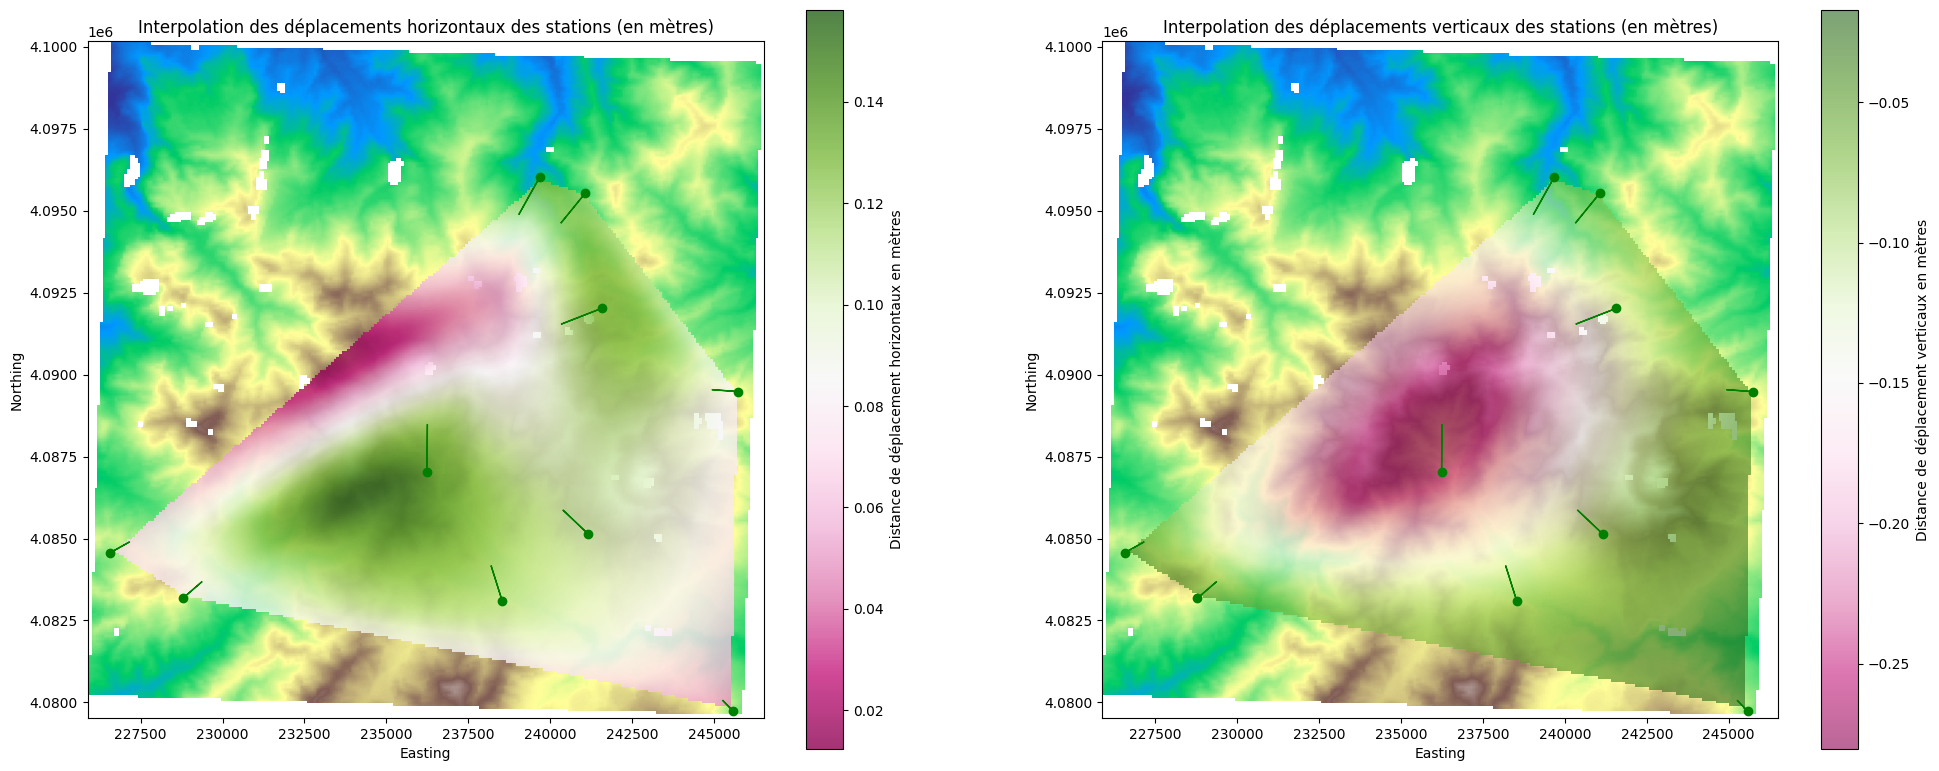

In [12]:
# Création d'une figure avec deux sous-graphes côte à côte
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 12))

# Affichage de la première carte
im1 = ax1.imshow(MNTvolcan, cmap='terrain', extent=cadre)
im1 = ax1.imshow(distance_corrected, cmap='PiYG', extent=cadre, alpha=0.8)

# Tracage des positions initiales
ax1.scatter(stations['Eastern'], stations['Northern'], color='green', label='Position Initiale')

# Tracage des vecteurs de déplacement avec une taille augmentée
for i in range(len(stations)):
    ax1.arrow(stations['Eastern'][i], stations['Northern'][i], 
              stations['U_east'][i]*10000, stations['U_north'][i]*10000, 
              head_width=0.05, head_length=0.1, fc='green', ec='green', length_includes_head=True)  # Augmenter scale

# Ajout d'une barre de couleur adaptée aux valeurs des distance horizontales
cbar1 = fig.colorbar(im1, ax=ax1, shrink=0.8)
cbar1.set_label('Distance de déplacement horizontaux en mètres')

ax1.set_xlabel('Easting')
ax1.set_ylabel('Northing')
ax1.set_title('Interpolation des déplacements horizontaux des stations (en mètres)')

# Tracage de la deuxième carte
im2 = ax2.imshow(MNTvolcan, cmap='terrain', extent=cadre)
im2 = ax2.imshow(grille_u_haut_corrected, cmap='PiYG', extent=cadre, alpha=0.6)

# Tracage des positions initiales
ax2.scatter(stations['Eastern'], stations['Northern'], color='green', label='Position Initiale')

# Tracage des vecteurs de déplacement avec une taille augmentée
for i in range(len(stations)):
    ax2.arrow(stations['Eastern'][i], stations['Northern'][i], 
              stations['U_east'][i]*10000, stations['U_north'][i]*10000, 
              head_width=0.05, head_length=0.1, fc='green', ec='green', length_includes_head=True)  # Augmenter scale

# Ajout d'une barre de couleur adaptée aux valeurs de distances verticales
cbar2 = fig.colorbar(im2, ax=ax2, shrink=0.8)
cbar2.set_label('Distance de déplacement verticaux en mètres')

ax2.set_xlabel('Easting')
ax2.set_ylabel('Northing')
ax2.set_title('Interpolation des déplacements verticaux des stations (en mètres)')

# enregistrement du graphique dans output afin de l'afficher dans le wiki
output_path = os.path.join(output_dir, 'cartes_interpolations.png')
fig.savefig(output_path, bbox_inches='tight')


# Affichage du graphique
plt.show()



